In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle_zillow
import evaluate
from matplotlib import style
from scipy.stats import pearsonr
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# PROJECT OVERVIEW

The goal of this project is to **find drivers of logerror** and **create a predictive model** that can predict the logerror of single family properties based on the features of the home. The model is trained on data from zillow found on kaggle and looks specifically at transactions for the year 2017.

    Note: logerror is the log of the difference between the actual sale price and the estimated price.

## Project Description

Zillow attempted with varying degrees of success to predict logerror based of off several data points. We will use a smaller subset of that data to train and test our models and eventually present the best performing model. Improvements and insights could then be refactored into larger scale models.

## Goals

1. Find the drivers of logerror. 
2. Make a model that performs better than baseline. 
3. Refine or create a better model. 
4. Give recommendations for new data to create better models.

## Aquiring Data


Data is store in codeups SQL database and a SQL query is run to pull the data. This is done using the wrangle_zillow.py module. wrangle_zillow.get_zillow_data() houses the SQL query and returns a pandas dataframe. This is then prepped by wrangle_zillow.py to be used in the exploration and modeling.

wrangle_zillow.wrangle_zillow() is the main function that calls the relevant functions to get, prep, and clean the data.

## Preparing Data

The data actually gets cleaned and aquired in one function call above. Some things to note about the preparation:
1. Nulls are removed because they are less than 1% of the data.
2. duplicate parcelIDs are removed.
3. The data is cleaned by removing outliers.
4. single units are selected based on unit count or landusetypeid if unitcount is missing.
5. missing data is filled if possible.
6. Transaction date is converted to q1, q2, q3, q4 and dummy variables are made.
7. Propertycountylandusecode is converted to a dummy variable.
8. Yearbuilt is converted to age of home based on 2017.
9. repetive features are removed as well as features with too many missing values.
10. LA county ends up being the only county with sufficent data. More models could be created to explore other counties.

This is also stored in .csv file for later use.

In [2]:
df=wrangle_zillow.wrangle_zillow()
df.head(3)

Reading prepped data from csv...


,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,q4 transactiondate,0101,0102,0103,0104,0108,010G,010M,0131,age
0,3.0,4.0,9.0,3039.0,2.0,33960230.0,-118006914.0,20028.0,6.037500e+07,14634.0,...,0,0,0,0,0,0,0,0,0,47.0
1,3.0,4.0,8.0,2540.0,2.0,34434971.0,-118464390.0,10384.0,6.037920e+07,54311.0,...,0,1,0,0,0,0,0,0,0,18.0
2,1.0,2.0,4.0,1146.0,7.0,34024040.0,-118159090.0,4657.0,6.037532e+07,17882.0,...,0,0,0,0,0,0,0,0,0,78.0


### Split the data

Data is split into train, validate, and test sets to prevent overfitting and to allow for data to be used to evaluate the model.


In [3]:
# split the data set into train, validate, and test
# here we use 'logerror' as the y value, and
train, validate, test,X_train,y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.split_data(df, y_value='logerror')

### Scale the data
The MinMaxScaler is first trained on the training data and then used to scale the data. The target is not scaled


In [4]:
#scale the data using wrangle_zillow.scale_data using MinMaxScaler
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.scale_numeric_columns(X_train, X_validate, X_test)
X_train_scaled.head()


,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,q4 transactiondate,0101,0102,0103,0104,0108,010G,010M,0131,age
13877,0.000000,0.285714,0.125,0.229302,1.0,0.572848,0.824037,0.345566,0.346894,0.389461,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527473
12183,0.666667,0.571429,0.625,0.503960,0.0,0.415558,0.662806,0.217697,0.513693,0.941001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472527
5066,0.666667,0.428571,0.625,0.531317,0.0,0.459331,0.552278,0.088035,0.494921,0.830772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098901
2952,0.666667,0.571429,0.625,0.919006,0.0,0.603505,0.880551,0.475477,0.340527,0.152658,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483516
19236,0.666667,0.571429,0.500,0.948524,0.0,0.774516,0.214335,0.450978,0.932062,0.953668,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164835


## Exploratory Data Analysis
Here I will look at the data and see if there are any interesting trends. Do some Hypothesis testing, statistical tests, and visualizations.

In [5]:
# pick the top correlation features
corr = abs(X_train_scaled.corrwith(y_train))
top_corr = corr.nlargest(8).index

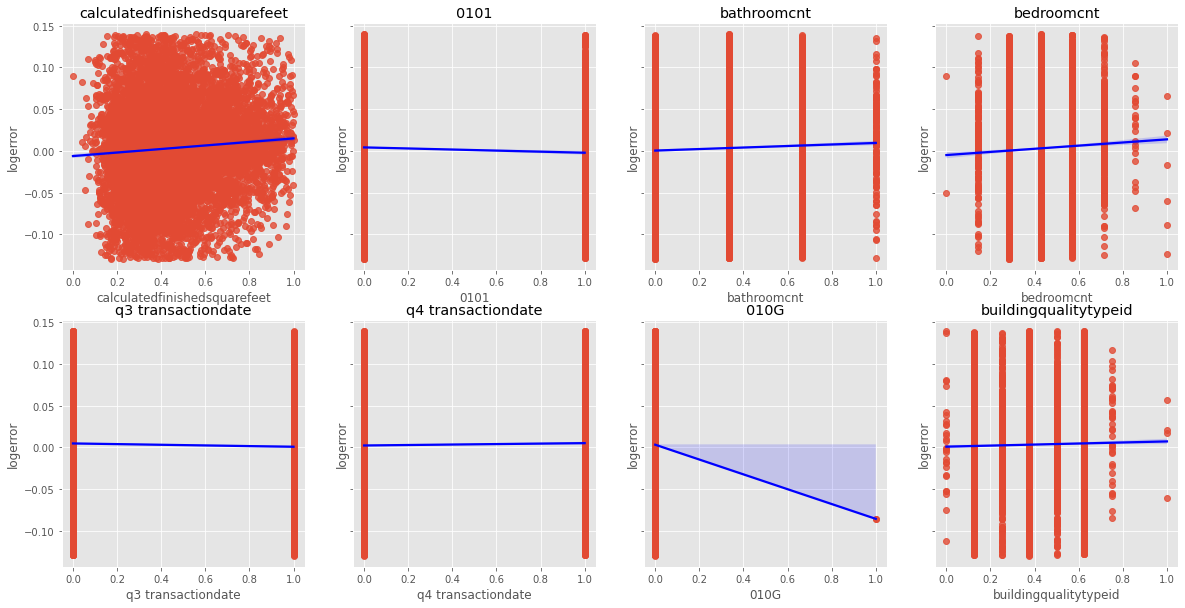

In [6]:
evaluate.graph_variables_vs_target(X_train_scaled[top_corr], train['logerror'])

looking at log error
1. Is there a correlation between log error and bathroom count?
2. Is there a correlation between log error and latitude?
3. Is there a correlation between log error and longitude?
4. Is there a correlation between log error and age?

## Question 1. Is there a correlation between log error and bathroom count?


    Lets test this hypothesis

$H_0$ : There is no linear relationship between bathroomcnt and the logerror.
 
$H_A$ : There is a linear relationship between bathroomcnt and the logerror.

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

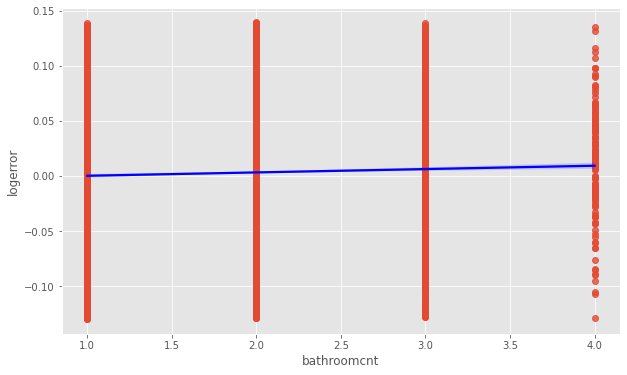

In [7]:
#plot correlation between logerror and bathroomcnt
plt.rcParams["figure.figsize"] = (10, 6)
sns.regplot(x="bathroomcnt", y="logerror", data=train, line_kws={"color": "blue"})



In [8]:
# stats test for logerror vs bathroomcnt
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['bathroomcnt'], train['logerror'])
r, p
# P-value is less than 0.05, so we reject null hypothesis


(0.04388565130306851, 3.9882978172649684e-06)

    Reject the null hypothesis and conclude that there is a linear relationship between bathroom and the value of the property.

~~$H_0$ : There is no linear relationship between bathroomcnt and the logerror.~~
 
$H_A$ : There is a linear relationship between bathroomcnt and the logerror.

## Question 2. Is there a correlation between log error and latitude?


    Lets test this hypothesis

$H_0$ : There is no linear relationship between latitude and the logerror.
 
$H_A$ : There is a linear relationship between latitude and the logerror.

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

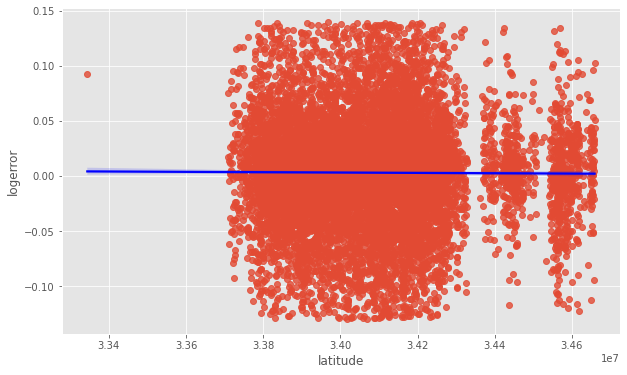

In [9]:
#plot correlation between logerror and bathroomcnt
sns.regplot(x="latitude", y="logerror", data=train, line_kws={"color": "blue"})


In [10]:
# stats test for logerror vs latitude
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['latitude'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.006406252627577998, 0.5009964816744279)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between latitude and the value of the property.

$H_0$ : There is no linear relationship between latitude and the logerror.
 
~~$H_A$ : There is a linear relationship between latitude and the logerror.~~

## Question 3. Is there a correlation between log error and longitude?


    Lets test this hypothesis

$H_0$ : There is no linear relationship between longitude and the logerror.
 
$H_A$ : There is a linear relationship between longitude and the logerror.

<AxesSubplot:xlabel='longitude', ylabel='logerror'>

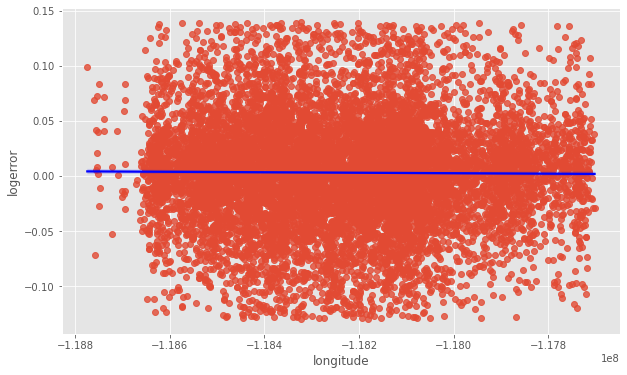

In [11]:
#plot correlation between logerror and longitude
sns.regplot(x="longitude", y="logerror", data=train, line_kws={"color": "blue"})


In [12]:
# stats test for logerror vs longitude
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['longitude'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.00969130041916129, 0.3086767015830554)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between longitude and the value of the property.

$H_0$ : There is no linear relationship between longitude and the logerror.
 
~~$H_A$ : There is a linear relationship between longitude and the logerror.~~

## Question 4. Is there a correlation between log error and age?

    Lets test this hypothesis

$H_0$ : There is no linear relationship between age and the logerror.
 
$H_A$ : There is a linear relationship between age and the logerror.

<AxesSubplot:xlabel='age', ylabel='logerror'>

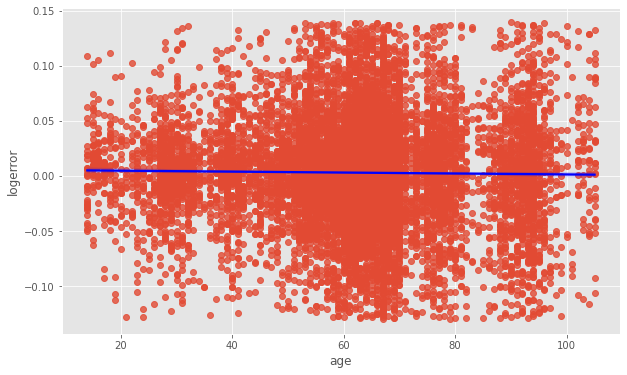

In [13]:
#plot correlation between logerror and age
sns.regplot(x="age", y="logerror", data=train, line_kws={"color": "blue"})

In [14]:
# stats test for logerror vs age
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['age'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.015185714839697316, 0.11066604930982041)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between age and the value of the property.

$H_0$ : There is no linear relationship between age and the logerror.
 
~~$H_A$ : There is a linear relationship between age and the logerror.~~

### Clustering
elbow method used to choose k value, this can be seen in the work.ipynb file.


In [15]:
#temp add logerror bins to help with visualizations
X_train_scaled['logerror_bins'] = pd.cut(train['logerror'], bins=[-.12, -.024, .0036 ,0.03, .13], labels=['low', 'medlow','medhigh', 'high'])


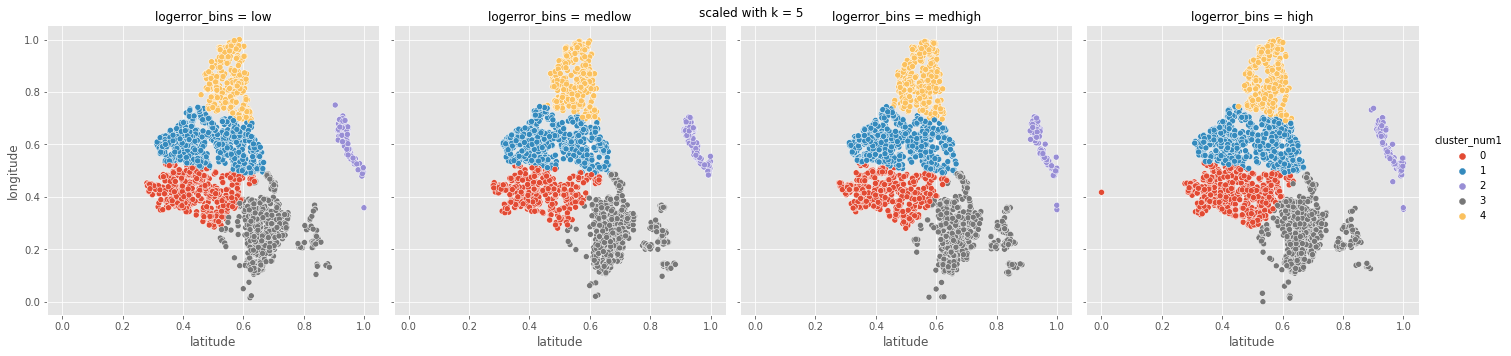

In [16]:
subset = X_train_scaled[["latitude","longitude"]]
evaluate.cluster(subset, 5, 1, X_train_scaled, X_validate_scaled, X_test_scaled)

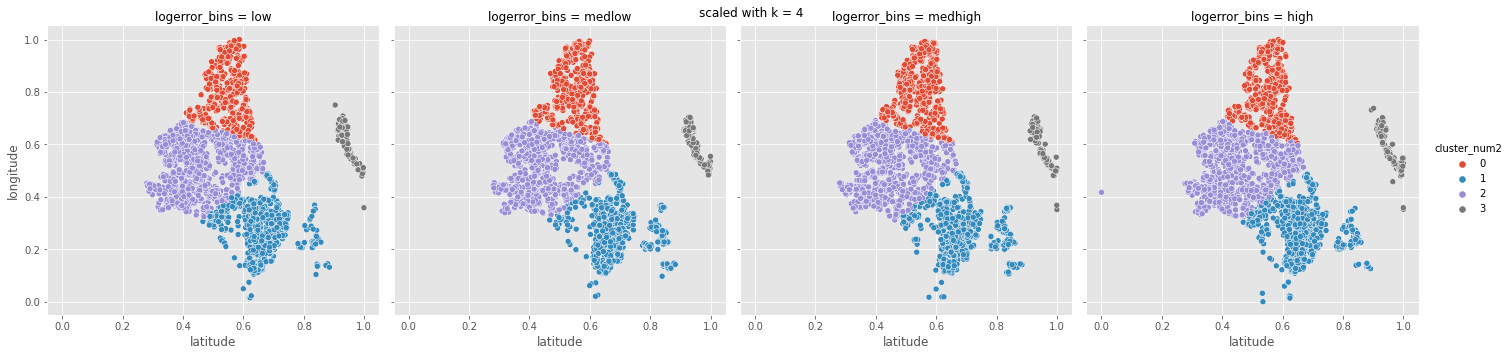

In [17]:
evaluate.cluster(subset, 4, 2, X_train_scaled, X_validate_scaled, X_test_scaled)

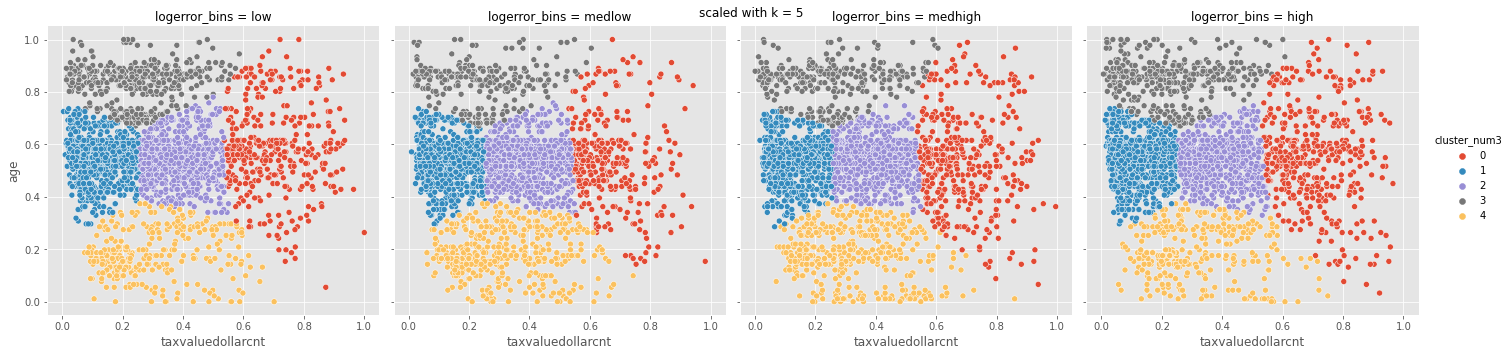

In [18]:
subset = X_train_scaled[["taxvaluedollarcnt","age"]]
evaluate.cluster(subset, 5, 3,X_train_scaled, X_validate_scaled, X_test_scaled)

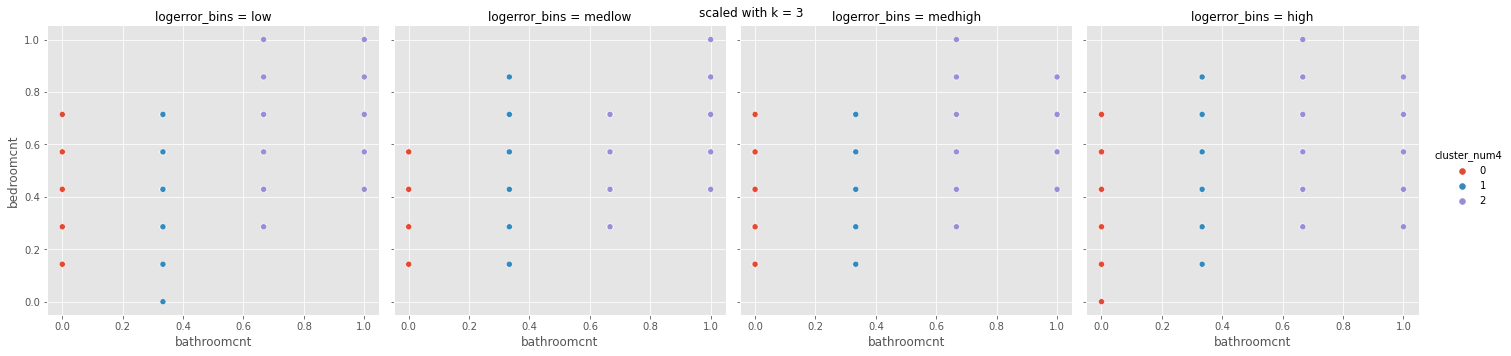

In [19]:
subset = X_train_scaled[["bathroomcnt","bedroomcnt"]]
evaluate.cluster(subset, 3, 4,X_train_scaled, X_validate_scaled, X_test_scaled)

In [20]:
# drop data leakage columns
X_train_scaled = X_train_scaled.drop(columns=['logerror_bins'])

### Looking at top features using RFE (recursive feature elimination)

In [21]:
#look at top feature
evaluate.select_RFE(X_train_scaled, y_train, 1)

Index(['010G'], dtype='object')

In [22]:
#look at top 5 features
evaluate.select_RFE(X_train_scaled, y_train, 5)

Index(['calculatedfinishedsquarefeet', 'landtaxvaluedollarcnt', 'taxamount',
       '010G', '0131'],
      dtype='object')

In [23]:
#look at top 10 features
evaluate.select_RFE(X_train_scaled, y_train, 10)



Index(['buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'landtaxvaluedollarcnt', 'taxamount', '0101', '0102', '0108', '010G',
       '010M', '0131'],
      dtype='object')

**Summary**

1. There is a linear relationship between bathroomcnt and the logerror.
2. There is a NO linear relationship between latitude and the logerror.
3. There is a NO linear relationship between longitude and the logerror.
4. There is a NO linear relationship between the buildings age and the logerror.
5. Propertycountylandusecode dummy features, quality, sqft, value, and tax appear important in predicting the logerror as seen by the RFE.  (RFE is a feature selection algorithm)
6. Several clusters were made with varying inputs and k values but none of them were significant and non were choosen by RFE models.

These features will be a great starting point for building a predictive model. It is important to note that several other features are also available, but due to time constraints we will not explore them yet.

## Modeling
First a baseline model is created and evaulated. The two most common baseline models are mean and median. We will use the best performing model based of of RMSE. RMSE will be the metric used to evaluate the models thereafter because it is a measure of the error in units relevant to the data (ie. how far off is the zestimate).

In [24]:
baseline_train = evaluate.baseline_mean_errors(y_train)['RMSE']
baseline_validate = evaluate.baseline_mean_errors(y_validate)['RMSE']

In [25]:
# mean performed slightly better than median
baseline_train = evaluate.baseline_mean_errors(y_train)['RMSE']
baseline_validate = evaluate.baseline_mean_errors(y_validate)['RMSE']
# build a dataframe to store rmse values
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','RMSE_train':baseline_train,'RMSE_validate':baseline_validate,'baseline':baseline_train,'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline
0,baseline,baseline,0.049095,0.047864,0.049095,False


### Run some models

In [26]:
model_results = evaluate.run_model(['bathroomcnt','bedroomcnt'], 1, X_train_scaled, X_validate_scaled, y_train, y_validate,baseline_train)
results = pd.concat([results, model_results],axis = 1)
# transpose it so each row is a model
results.T.reset_index(drop=True)

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline,features
0,baseline,baseline,0.049095,0.047864,0.049095,False,NaN
1,1,Linear Regression,0.049035,0.047817,0.049095,True,"[bathroomcnt, bedroomcnt]"


In [27]:
# adjust the number of features to select, use those features, and run the model
for i in range(1,10):
    features = evaluate.select_RFE(X_train_scaled, y_train, k=i).to_list()
    model_results = evaluate.run_model(features, (i+1), X_train_scaled, X_validate_scaled, y_train, y_validate, baseline_train)
    results = pd.concat([results, model_results],axis = 1)

In [28]:
results.T.reset_index(drop=True).head(3)

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline,features
0,baseline,baseline,0.049095,0.047864,0.049095,False,NaN
1,1,Linear Regression,0.049035,0.047817,0.049095,True,"[bathroomcnt, bedroomcnt]"
2,2,Linear Regression,0.04908,0.047904,0.049095,True,[010G]


In [29]:
clusters= ['cluster_num1', 'cluster_num2', 'cluster_num3', 'cluster_num4']

In [30]:
# run the models again, but this time with 1 cluster added
model_num =11
for i in range(len(clusters)):
    cluster = clusters[i]
    for j in range(1,10):
        features = evaluate.select_RFE(X_train_scaled, y_train, k=j).to_list()
        features.append(cluster)
        model_results = evaluate.run_model(features, model_num,X_train_scaled, X_validate_scaled, y_train, y_validate, baseline_train)
        results = pd.concat([results, model_results],axis = 1)
        model_num += 1

In [31]:
# results transposed to be easier to read
results = results.T.reset_index(drop=True)
# sort by rmse_validate
results.sort_values(by=['RMSE_validate'], inplace=True)
results.head()

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline,features
28,28,Linear Regression,0.048708,0.047585,0.049095,True,"[calculatedfinishedsquarefeet, landtaxvaluedol..."
19,19,Linear Regression,0.048703,0.047587,0.049095,True,"[calculatedfinishedsquarefeet, landtaxvaluedol..."
37,37,Linear Regression,0.048732,0.047653,0.049095,True,"[calculatedfinishedsquarefeet, landtaxvaluedol..."
10,10,Linear Regression,0.048737,0.047661,0.049095,True,"[calculatedfinishedsquarefeet, landtaxvaluedol..."
46,46,Linear Regression,0.04873,0.04767,0.049095,True,"[calculatedfinishedsquarefeet, landtaxvaluedol..."


In [32]:
# look at features for model number 28
best_features = results.loc[28, 'features']
best_features

['calculatedfinishedsquarefeet',
 'landtaxvaluedollarcnt',
 'taxamount',
 '0101',
 '0102',
 '0108',
 '010G',
 '010M',
 '0131',
 'cluster_num2']

In [33]:
evaluate.run_on_test(best_features, X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, baseline_train)

model_number                          46
model_type              LinearRegression
number_of_features                    10
RMSE_train                      0.048708
RMSE_validate                   0.047585
RMSE_test                       0.047795
baseline                        0.049095
better_than_baseline                True
dtype: object

## Modeling summary
200+ models were run but all are linear regression. With more time I would like to try out more complex models with even more feature combinations.
I would also like to fit and run models based on individual clusters.

However, the best model performed 0.001 better on the test set than the baseline model did on the train set.

## CONCLUSION
### Drivers of logerror
'Propertycountylandusecode', 'calculatedfinishedsquarefeet', 'landtaxvaluedollarcnt', 'taxamount' are the most important drivers of logerror.

### Model improvement
Our models almost all perform better than the baseline model. With one having a RMSE of 0.001 better than the baseline. I would like to try different ways to scale the data and remove outliers, and reconfigure clusters

I would also like to look at making three different models for each cluster.

### Recommendations
More features I would add in would be proximity to important locations such as hospitals, schools, police departments, beaches, as well as crime rates.


## Sneak Peak to next model
RMSE improvement of 0.005
by spliting models by cluster

In [34]:


'''
	model_type	        RMSE_train	RMSE_validate	baseline	better_than_baseline
model_number						
0	baseline	        0.049098	0.047868	    0.049098	False
1	Linear Regression	0.046202	0.046094	    0.049098	True	
2	Linear Regression	0.048712	0.046649	    0.049098	True	
3	Linear Regression	0.050511	0.049691	    0.049098	False	
4	Linear Regression	0.042226	0.043766	    0.049098	True	
'''

'\nRMSE_train\tRMSE_validate\tbaseline\tbetter_than_baseline\nmodel_number\t\t\t\t\n0\t0.049098\t0.047868\t0.049098\t0.000000\n1\t0.046377\t0.046240\t0.049098\t1.000000\n2\t0.048900\t0.046666\t0.049098\t1.000000\n3\t0.050633\t0.049738\t0.049098\t0.000000\n4\t0.042445\t0.043899\t0.049098\t1.000000\n'